In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def transition_per_row(img):
    trans_array = []
    for i in range(img.shape[0]):
        trans = 0
        new_region = True
        for j in range(img.shape[1]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    new_region = False
            if(~img[i][j]):
                new_region = True
        trans_array.append(trans)
    trans_median = np.median(trans_array)
    return int(trans_median)


def transition_per_column(img):
    trans_array = []
    for j in range(img.shape[1]):
        trans = 0
        new_region = True
        for i in range(img.shape[0]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    new_region = False
            if(~img[i][j]):
                new_region = True
        trans_array.append(trans)
    trans_median = np.median(trans_array)
    return int(trans_median)


In [35]:
def get_locations_column(img, num):
    locations_array = []
    for i in range(img.shape[0]):
        locations = []
        trans = 0
        new_region = True
        for j in range(img.shape[1]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    locations.append(j)
                    new_region = False
            if(~img[i][j]):
                new_region = True
        if(trans == num):
            locations_array.append(locations)
    locations_array = np.array(locations_array)
    median_location = []
    if (len(locations_array) != 0):
        for k in range(num):
            median_location.append(np.median(locations_array[:, k]))
    return np.array(median_location, dtype=np.int32)


def get_locations_row(img, num):
    locations_array = []
    for j in range(img.shape[1]):
        locations = []
        trans = 0
        new_region = True
        for i in range(img.shape[0]):
            if(new_region):
                if(img[i][j]):
                    trans += 1
                    locations.append(i)
                    new_region = False
            if(~img[i][j]):
                new_region = True
        if(trans == num):
            locations_array.append(locations)
    locations_array = np.array(locations_array)
    median_location = []
    if (len(locations_array) != 0):
        for k in range(num):
            median_location.append(np.median(locations_array[:, k]))
    return np.array(median_location, dtype=np.int32)


In [36]:
def remove_border(img_with_border):
    img_with_border_v = cv2.erode(img_with_border, np.ones(
        (15, 1), np.uint8), iterations=1)  # !Parameter
    img_with_border_v = cv2.dilate(img_with_border_v, np.ones(
        (1, 5), np.uint8), iterations=1)  # !Parameter
    img_with_border_v = cv2.erode(img_with_border_v, np.ones(
        (1, 4), np.uint8), iterations=1)  # !Parameter
    img_with_border_h = cv2.erode(img_with_border, np.ones(
        (1, 15), np.uint8), iterations=1)  # !Parameter
    img_with_border_h = cv2.dilate(img_with_border_h, np.ones(
        (5, 1), np.uint8), iterations=1)  # !Parameter
    img_with_border_h = cv2.erode(img_with_border_h, np.ones(
        (3, 1), np.uint8), iterations=1)  # !Parameter
    img_without_border = img_with_border.copy()
    # upper border
    for j in range(img_without_border.shape[1]):
        i = 0
        while(i < img_without_border.shape[0] and img_with_border_h[i][j] != 0):
            img_without_border[i][j] = 0
            i += 1
    # lower border
    for j in range(img_without_border.shape[1]):
        i = img_without_border.shape[0]-1
        while(i >= 0 and img_with_border_h[i][j] != 0):
            img_without_border[i][j] = 0
            i -= 1
    # left border
    for i in range(img_without_border.shape[0]):
        j = 0
        while(j < img_without_border.shape[1] and img_with_border_v[i][j] != 0):
            img_without_border[i][j] = 0
            j += 1
    # right border
    for i in range(img_without_border.shape[0]):
        j = img_without_border.shape[1]-1
        while(j >= 0 and img_with_border_v[i][j] != 0):
            img_without_border[i][j] = 0
            j -= 1
    # border final clean
    for j in range(img_without_border.shape[1]):
        for i in range(3):
            img_without_border[i][j] = 0
    for j in range(img_without_border.shape[1]):
        for i in range(img_without_border.shape[0]-3, img_without_border.shape[0]):
            img_without_border[i][j] = 0
    for i in range(img_without_border.shape[0]):
        for j in range(3):
            img_without_border[i][j] = 0
    for i in range(img_without_border.shape[0]):
        for j in range(img_without_border.shape[1]-3, img_without_border.shape[1]):
            img_without_border[i][j] = 0
    img_without_border = cv2.dilate(
        img_without_border, np.ones((1, 2), np.uint8), iterations=1)
    img_without_border = cv2.erode(
        img_without_border, np.ones((1, 2), np.uint8), iterations=1)
    img_without_border = cv2.dilate(
        img_without_border, np.ones((2, 1), np.uint8), iterations=1)
    img_without_border = cv2.erode(
        img_without_border, np.ones((2, 1), np.uint8), iterations=1)
    return img_without_border


In [37]:
def get_cells(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_binary = cv2.adaptiveThreshold(gray, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4)
    kernal_width = 3  # !Parameter
    iterations = 8  # !Parameter
    kernel = np.ones((1, kernal_width), np.uint8)
    img_horizontal = cv2.erode(img_binary, kernel, iterations=iterations)
    img_horizontal = cv2.dilate(img_horizontal, kernel, iterations=iterations)
    num_rows = transition_per_column(img_horizontal)
    kernal_height = 3  # !Parameter
    iterations = 8  # !Parameter
    kernel = np.ones((kernal_height, 1), np.uint8)
    img_vertical = cv2.erode(img_binary, kernel, iterations=iterations)
    img_vertical = cv2.dilate(img_vertical, kernel, iterations=iterations)
    num_columns = transition_per_row(img_vertical)
    locations_columns = get_locations_column(img_vertical, num_columns)
    locations_rows = get_locations_row(img_horizontal, num_rows)
    location_cells_rows = []
    for k in range(num_columns-1):
        location_2 = []
        for j in range(locations_columns[k], locations_columns[k+1]+1):
            trans = 0
            location_1 = []
            new_region = True
            for i in range(img_horizontal.shape[0]):
                if(new_region):
                    if(img_horizontal[i][j]):
                        trans += 1
                        location_1.append(i)
                        new_region = False
                if(~img_horizontal[i][j]):
                    new_region = True
            if(trans == num_rows):
                location_2.append(location_1)
        if(len(location_2) == 0):
            location_2.append(locations_rows)
        median_location = np.median(location_2, axis=0)
        median_location = np.array(median_location, dtype=np.int32)
        location_cells_rows.append(median_location)
    location_cells_columns = []
    for k in range(num_rows-1):
        location_2 = []
        for i in range(locations_rows[k], locations_rows[k+1]+1):
            trans = 0
            location_1 = []
            new_region = True
            for j in range(img_vertical.shape[1]):
                if(new_region):
                    if(img_vertical[i][j]):
                        trans += 1
                        location_1.append(j)
                        new_region = False
                if(~img_vertical[i][j]):
                    new_region = True
            if(trans == num_columns):
                location_2.append(location_1)
        if(len(location_2) == 0):
            location_2.append(locations_columns)
        median_location = np.median(location_2, axis=0)
        median_location = np.array(median_location, dtype=np.int32)
        location_cells_columns.append(median_location)
    cells_locations = []
    for i in range(num_rows-1):
        for j in range(num_columns-1):
            cells_locations.append(
                (location_cells_rows[j][i], location_cells_columns[i][j],
                 location_cells_rows[j][i+1], location_cells_columns[i][j+1])
            )
    cells_content = []
    cell_row_content = []
    for i in range(len(cells_locations)):
        cell_row_content.append(gray[cells_locations[i][0]:cells_locations[i]
                                [2], cells_locations[i][1]:cells_locations[i][3]])
        if((i+1) % (num_columns-1) == 0):
            cells_content.append(cell_row_content)
            cell_row_content = []

    for i in range(len(cells_content)):
        for j in range(len(cells_content[i])):
            cells_content[i][j] = cv2.threshold(
                cells_content[i][j], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    for i in range(len(cells_content)):
        for j in range(len(cells_content[i])):
            cells_content[i][j] = remove_border(cells_content[i][j])
    return cells_content


In [38]:
img = cv2.imread('./9.jpeg')
cells = get_cells(img)

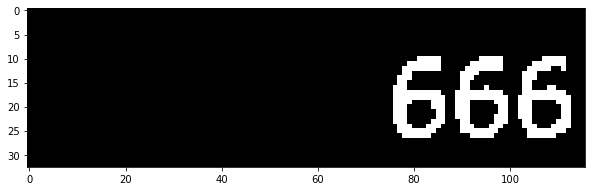

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(cells[0][5], cmap='gray')
plt.show()